<a href="https://colab.research.google.com/github/Deegayu-Mihiraj/Bank-Marketing-ML-Project/blob/main/ML%20CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import joblib

Mount Google Drive and import dataset

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
bankdataset = pd.read_csv('/content/drive/MyDrive/Machine Learning/CW/bank-full.csv', sep=';')

***Data Preprocessing***

In [146]:
# Drop 'duration' column for realistic predictive modeling
bankdataset.drop(columns=['duration'], inplace=True)

In [147]:
bankdataset.shape

(45211, 16)

In [148]:
bankdataset.isin(['unknown']).sum()


,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day,0


In [149]:
# List of columns where "unknown" should be replaced with the mode
selected_columns = ['job', 'education']

# Replace "unknown" with the mode for the selected columns
for col in selected_columns:
    mode = bankdataset[col].mode()[0]
    bankdataset[col] = bankdataset[col].replace('unknown', mode)


In [150]:
#numeric and categoric columns
integer_columns = bankdataset.select_dtypes(include=['int64'])
string_columns = bankdataset.select_dtypes(include=['object'])

In [151]:
# Remove punctuation
import string

string_columns = bankdataset.select_dtypes(include=['object'])
bankdataset[string_columns.columns] = string_columns.apply(
    lambda col: col.str.replace(f"[{string.punctuation}]", "", regex=True)
)


In [152]:
# Encoding categorical variables
label_encoders = {}
for col in string_columns.columns:
    le = LabelEncoder()
    bankdataset[col] = le.fit_transform(bankdataset[col])
    label_encoders[col] = le

# Encoding target variable 'y'
if 'y' not in label_encoders:  # Check if 'y' is already in label_encoders
    le_y = LabelEncoder()
    bankdataset['y'] = le_y.fit_transform(bankdataset['y'])
    label_encoders['y'] = le_y

In [153]:
# Scaling numeric features
scaler = StandardScaler()
integer_columns_scaled = scaler.fit_transform(bankdataset[integer_columns.columns])
integer_columns_scaled_df = pd.DataFrame(integer_columns_scaled, columns=integer_columns.columns)

# Combine scaled numeric features with encoded categorical features
bankdataset_preprocessed = pd.concat([integer_columns_scaled_df, bankdataset[string_columns.columns]], axis=1)

In [154]:
# Splitting the dataset into train and test sets
X = bankdataset_preprocessed.drop(columns=['y'])
y = bankdataset_preprocessed['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest

Random Forest Classifier Evaluation
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7952
           1       0.70      0.20      0.31      1091

    accuracy                           0.89      9043
   macro avg       0.80      0.59      0.62      9043
weighted avg       0.88      0.89      0.87      9043

Accuracy: 0.8929558774742895


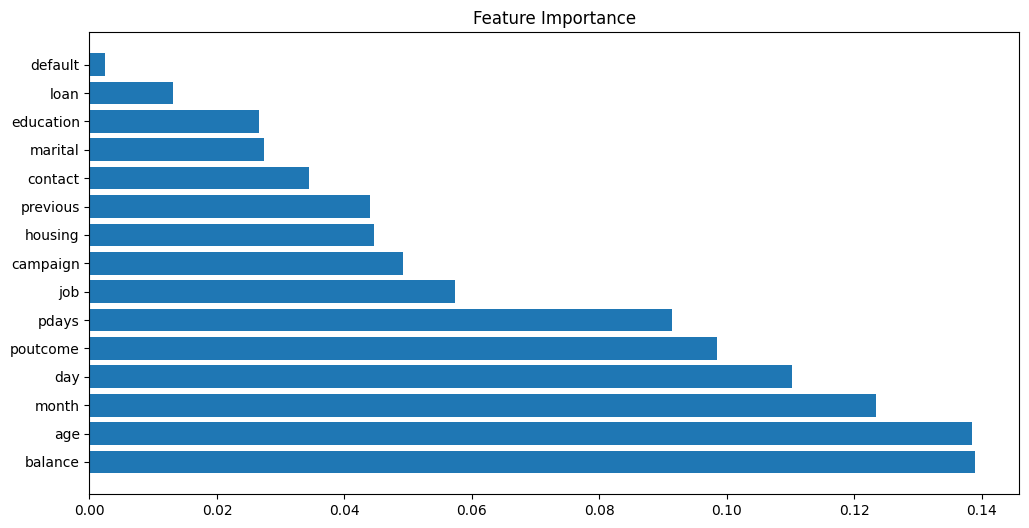

In [155]:
# Train Random Forest Classifier (max_depth to reduce overfitting)
ranfor_model = RandomForestClassifier(random_state=54, max_depth=15)
ranfor_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf = ranfor_model.predict(X_test)
print("Random Forest Classifier Evaluation")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


importances = ranfor_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.barh(X_train.columns[indices], importances[indices])
plt.title("Feature Importance")
plt.show()


Feedforward Neural Network

In [ ]:
# Neural Network Model
FF_NN_Model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer='l2'),  # 1 hidden layer
    Dropout(0.3),  # Dropout  regularization
    Dense(64, activation='relu', kernel_regularizer='l2'),  # 2 hidden layer
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # OL for binary classification
])

# Compile the Model
FF_NN_Model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the Model
history = FF_NN_Model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
FF_NN_loss, FF_NN_accuracy = FF_NN_Model.evaluate(X_test, y_test)
print("Neural Network Accuracy on Test Data:", FF_NN_accuracy)
print("Neural Network Loss on Test Data:", FF_NN_loss)

# Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()


Epoch 1/50
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8617 - loss: 0.8094 - val_accuracy: 0.8794 - val_loss: 0.3701 - learning_rate: 0.0010
Epoch 2/50
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8846 - loss: 0.3547 - val_accuracy: 0.8794 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 3/50
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8850 - loss: 0.3453 - val_accuracy: 0.8794 - val_loss: 0.3522 - learning_rate: 0.0010
Epoch 4/50
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8837 - loss: 0.3436 - val_accuracy: 0.8794 - val_loss: 0.3556 - learning_rate: 0.0010
Epoch 5/50
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8849 - loss: 0.3378 - val_accuracy: 0.8794 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 6/50
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8839 - loss: 0.3399 - val_accuracy: 0.8794 - val_loss: 0.3468 - learning_rate: 0.0010
Epoch 7/50
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8847 -

In [68]:
# Get predictions
y_pred_probabilities = FF_NN_Model.predict(X_test)

# first 10 predictions
print("Predicted probabilities for y:")
print(y_pred_probabilities[:10])

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted probabilities for y:
[[0.04384886]
 [0.07361259]
 [0.15188588]
 [0.31860882]
 [0.10909812]
 [0.14367461]
 [0.16907617]
 [0.12382834]
 [0.09094507]
 [0.0457539 ]]
Predicted binary class for y:
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [48]:
# Save the Random Forest Model
joblib.dump(rf_model, 'random_forest_model.pkl')
print("Random Forest model saved")

# Save the Neural Network Model
FF_NN_Model.save('neural_network_model.h5')
print("Neural Network model saved")

# Summary Comparison of Models
print("Summary Comparison:")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Neural Network Accuracy: {FF_NN_accuracy}")

Summary Comparison:
Random Forest Accuracy: 0.8929558774742895
Neural Network Accuracy: 0.8809023499488831
